In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import re

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.measurement
print(Measurement)
print(Station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.measurement'>


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<AxesSubplot:xlabel='Date'>

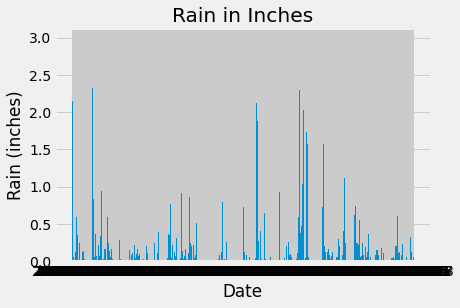

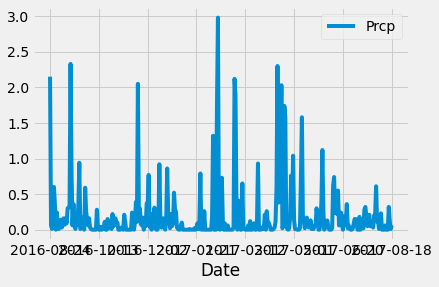

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
# Calculate the date one year from the last date in data set.
prev_year = dt.datetime(2017, 8, 23) - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= prev_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results)
results_df = results_df.rename(columns = {0:"Date", 1:"Prcp"})
# Sort the dataframe by date
results_df.sort_values("Date")
results_df.set_index(results_df["Date"], inplace = True)
# Use Pandas Plotting with Matplotlib to plot the data
#plt.figure(figsize=(20,3))
plt.bar(results_df.index, results_df["Prcp"])
plt.title("Rain in Inches")
plt.xlabel("Date")
plt.ylabel("Rain (inches)")
results_df.plot()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,Prcp
count,351.000000
mean,0.194416
std,0.411050
min,0.000000
25%,0.000000
50%,0.060000
75%,0.185000
max,2.980000


In [12]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).group_by(Measurement.station).all()

[(1979,),
 (2709,),
 (2202,),
 (2612,),
 (1372,),
 (511,),
 (2772,),
 (2724,),
 (2669,)]

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station =='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= prev_year).all()
results_df["Temp"] = temps
results_df = results_df.drop("Date",axis='columns')
print(results_df)

            Prcp    Temp
Date                    
2016-08-24  2.15  (77.0)
2016-08-25  0.06  (80.0)
2016-08-26  0.01  (80.0)
2016-08-27  0.12  (75.0)
2016-08-28  0.60  (73.0)
...          ...     ...
2017-08-14  0.00  (77.0)
2017-08-15  0.32  (77.0)
2017-08-16  0.12  (76.0)
2017-08-17  0.01  (76.0)
2017-08-18  0.06  (79.0)

[351 rows x 2 columns]


In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(date1, date2):
    date1y = int(re.match(r'^\d{4}',date1).group(0))
    date1m = int(re.search(r'(?<=\d{4}-)\d{2}',date1).group(0))
    date1d = int(re.search(r'\d{2}$',date1).group(0))
    date2y = int(re.match(r'^\d{4}',date2).group(0))
    date2m = int(re.search(r'(?<=\d{4}-)\d{2}',date2).group(0))
    date2d = int(re.search(r'\d{2}$',date2).group(0))
    select_temps = session.query(Measurement.tobs).filter((Measurement.date >= dt.datetime(date1y,date1m,date1d)) & (Measurement.date <= dt.datetime(date2y,date2m,date2d))).all()
    return select_temps

In [17]:
# Challenge

In [18]:
June_temps = calc_temps('2010-06-01', '2010-06-30')
June_temps.extend(calc_temps('2011-06-01', '2011-06-30'))
June_temps.extend(calc_temps('2012-06-01', '2012-06-30'))
June_temps.extend(calc_temps('2013-06-01', '2013-06-30'))
June_temps.extend(calc_temps('2014-06-01', '2014-06-30'))
June_temps.extend(calc_temps('2015-06-01', '2015-06-30'))
June_temps.extend(calc_temps('2016-06-01', '2016-06-30'))
June_temps.extend(calc_temps('2017-06-01', '2017-06-30'))
June_temps_df = pd.DataFrame(June_temps)

In [57]:
June_temps_df = June_temps_df.rename(columns={0:"June Temps"})
June_temps_df

,June Temps
0,76.0
1,78.0
2,76.0
3,77.0
4,78.0
...,...
1638,79.0
1639,74.0
1640,74.0
1641,76.0


In [58]:
June_temps_df.describe()

,June Temps
count,1643.000000
mean,74.955569
std,3.239314
min,65.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


In [53]:
December_temps = calc_temps('2010-12-01', '2010-12-30')
December_temps.extend(calc_temps('2011-12-01', '2011-12-30'))
December_temps.extend(calc_temps('2012-12-01', '2012-12-30'))
December_temps.extend(calc_temps('2013-12-01', '2013-12-30'))
December_temps.extend(calc_temps('2014-12-01', '2014-12-30'))
December_temps.extend(calc_temps('2015-12-01', '2015-12-30'))
December_temps.extend(calc_temps('2016-12-01', '2016-12-30'))
December_temps.extend(calc_temps('2017-12-01', '2017-12-30'))
December_temps_df = pd.DataFrame(December_temps)

In [55]:
December_temps_df = December_temps_df.rename(columns={0:"December Temps"})
December_temps_df

,December Temps
0,74.0
1,74.0
2,64.0
3,64.0
4,67.0
...,...
1421,71.0
1422,71.0
1423,71.0
1424,69.0


In [56]:
December_temps_df.describe()

,December Temps
count,1426.000000
mean,71.095372
std,3.676672
min,57.000000
25%,69.000000
50%,71.000000
75%,74.000000
max,83.000000
